## Part 3 - Further Analysis
-------

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [4]:
!pip install google-cloud-bigquery-storage

### Hourly Trip Distribution

The timestamps in the bikeshare data are in the standard format: "2015-09-24 17:22:00 UTC". Initial analysis of Bay Area trip times included a conversion from UTC to PST; however, this produced anomalous results.

In [5]:
%%bigquery faulty_weekday_subscriber_trip_times
SELECT
    EXTRACT(
        HOUR FROM end_date
        AT TIME ZONE "America/Los_Angeles"
    ) AS trip_time
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE subscriber_type = "Subscriber"
AND EXTRACT(
    DAYOFWEEK FROM end_date
    AT TIME ZONE "America/Los_Angeles"
) BETWEEN 2 AND 6
AND SUBSTRING(zip_code, 1, 2) = "94"

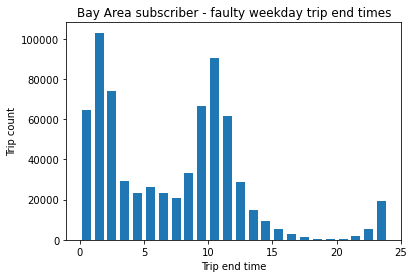

In [6]:
plt.hist(faulty_weekday_subscriber_trip_times, 24, range=[0, 24], rwidth=0.7, histtype='bar');
plt.title('Bay Area subscriber - faulty weekday trip end times')
plt.xlabel('Trip end time')
plt.ylabel('Trip count')
plt.show()

Initial analysis applied a UTC to PST conversion on all timestamps. The result shown above suggested that Bay Area subscribers rode bikes most frequently between 12-3am and 9-12am on weekdays.

In [7]:
%%bigquery faulty_weekend_subscriber_trip_times
SELECT
    EXTRACT(
        HOUR FROM end_date
        AT TIME ZONE "America/Los_Angeles"
    ) AS trip_time
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE subscriber_type = "Subscriber"
AND EXTRACT(
    DAYOFWEEK FROM end_date
    AT TIME ZONE "America/Los_Angeles"
) NOT BETWEEN 2 AND 6
AND SUBSTRING(zip_code, 1, 2) = "94"

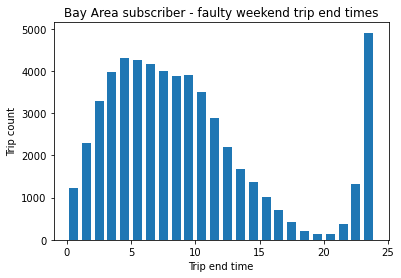

In [8]:
plt.hist(faulty_weekend_subscriber_trip_times, 24, range=[0, 24], rwidth=0.7, histtype='bar');
plt.title('Bay Area subscriber - faulty weekend trip end times')
plt.xlabel('Trip end time')
plt.ylabel('Trip count')
plt.show()

The same faulty analysis applied to Bay Area subscriber trips on weekends showed a large jump at 11pm-12am, corresponding to the 12-3am weekday subscriber rush. These results were convincing evidence that the timestamps in the bikeshare dataset were not actually in UTC, but became labelled as UTC as an artifact of data formatting.

<a id='q3'></a>
Repeating the analysis without the UTC to PST conversion produced more realistic results. The queries in [Part 2](Project_1_Part2.md#Question-1---Trip-Distributions) were corrected to match.

In [9]:
%%bigquery weekday_subscriber_trip_times
SELECT
    EXTRACT(
        HOUR FROM end_date
    ) AS trip_time
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE subscriber_type = "Subscriber"
AND EXTRACT(
    DAYOFWEEK FROM end_date
) BETWEEN 2 AND 6
AND SUBSTRING(zip_code, 1, 2) = "94"

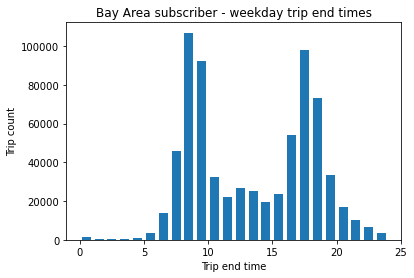

In [10]:
plt.hist(weekday_subscriber_trip_times, 24, range=[0, 24], rwidth=0.7, histtype='bar');
plt.title('Bay Area subscriber - weekday trip end times')
plt.xlabel('Trip end time')
plt.ylabel('Trip count')
plt.show()

Not applying a UTC to PST timestamp conversion produced peaks at more realistic times: 7-10am and 4-7pm.

In [11]:
%%bigquery weekend_subscriber_trip_times
SELECT
    EXTRACT(
        HOUR FROM end_date
    ) AS trip_time
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE subscriber_type = "Subscriber"
AND EXTRACT(
    DAYOFWEEK FROM end_date
) NOT BETWEEN 2 AND 6
AND SUBSTRING(zip_code, 1, 2) = "94"

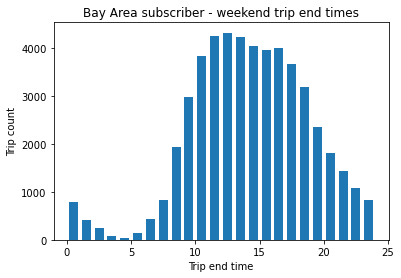

In [12]:
n, bins, patches = plt.hist(weekend_subscriber_trip_times, 24, range=[0, 24], rwidth=0.7, histtype='bar')
plt.title('Bay Area subscriber - weekend trip end times')
plt.xlabel('Trip end time')
plt.ylabel('Trip count')
plt.show()

In [13]:
%%bigquery weekday_customer_trip_times
SELECT
    EXTRACT(
        HOUR FROM end_date
    ) AS trip_time
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE subscriber_type = "Customer"
AND EXTRACT(
    DAYOFWEEK FROM end_date
) BETWEEN 2 AND 6
AND SUBSTRING(zip_code, 1, 2) = "94"

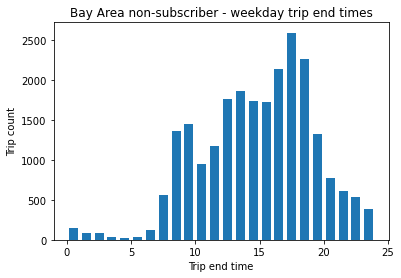

In [14]:
n, bins, patches = plt.hist(weekday_customer_trip_times, 24, range=[0, 24], rwidth=0.7, histtype='bar')
plt.title('Bay Area non-subscriber - weekday trip end times')
plt.xlabel('Trip end time')
plt.ylabel('Trip count')
plt.show()

In [15]:
%%bigquery weekend_customer_trip_times
SELECT
    EXTRACT(
        HOUR FROM end_date
    ) AS trip_time
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE subscriber_type = "Customer"
AND EXTRACT(
    DAYOFWEEK FROM end_date
) NOT BETWEEN 2 AND 6
AND SUBSTRING(zip_code, 1, 2) = "94"

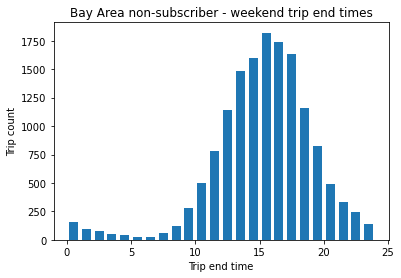

In [16]:
n, bins, patches = plt.hist(weekend_customer_trip_times, 24, range=[0, 24], rwidth=0.7, histtype='bar')
plt.title('Bay Area non-subscriber - weekend trip end times')
plt.xlabel('Trip end time')
plt.ylabel('Trip count')
plt.show()

Under this improved analysis, Bay Area subscribers behaved like commuters on weekdays, with trips peaking 7-10am and 4-7pm. [Part 2](Project_1_Part2.md#Question-3---Commuter-Trips) lists the most common morning and afternoon Bay Area commuter trips.

Bay Area non-subscribers (labelled in dataset as "Customers") never behaved like commuters on weekdays or weekends, with trips being broadly distributed during daylight hours.

However, the weekend trip distribution for non-subscribers peaks during prime afternoon hours at 1-6pm, suggestive of tourist or recreational behavior. [Part 2](Project_1_Part2.md#Question-2---Popular-Trips) corrobates this by showing that most of the popular weekend trips for Bay Area non-subscribers involved stations along the pier district. With further analysis, this tendency can be targeted with promotional deals.

<a id='q4'></a>
### Identical Trips

Identical trips have the same starting station, starting timestamp, ending station, and ending timestamp. Such trips have a higher likelihood of being made by associated people, such as friends or groups of tourists.

According to [Part 2](Project_1_Part2.md#Question-4---Identical-Trips), In the entire dataset, 19% of non-subscriber trips were identical trips, but only 13% of non-subscriber trips in the Bay Area were identical trips. A lower fraction of non-subscribers made identical trips in the Bay Area, which suggests that more people may have opted against using the bikeshare program than the global average.

In [17]:
%%bigquery popular_identical_starts
SELECT
    start_station_name,
    latitude,
    longitude,
    SUM(identical_trips) AS total_identical_trips
FROM (
    SELECT
        start_station_name,
        latitude,
        longitude,
        end_station_name,
        start_date,
        end_date,
        COUNT(*) AS identical_trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` AS Trips
    JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS Stations
    ON Trips.start_station_id = Stations.station_id
    WHERE subscriber_type = "Customer"
    AND SUBSTRING(zip_code, 1, 2) = "94"
    GROUP BY 
        start_station_name,
        latitude,
        longitude,
        end_station_name,
        start_date,
        end_date
)
WHERE identical_trips != 1
GROUP BY
    start_station_name,
    latitude,
    longitude
ORDER BY total_identical_trips DESC
LIMIT 10

In [18]:
popular_identical_starts.set_index('start_station_name', inplace=True)
popular_identical_starts

,latitude,longitude,total_identical_trips
start_station_name,,,
Embarcadero at Sansome,37.804770,-122.403234,609
Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,547
2nd at Townsend,37.780526,-122.390288,247
Embarcadero at Vallejo,37.799953,-122.398525,231
Embarcadero at Bryant,37.787152,-122.388013,209
Steuart at Market,37.794139,-122.394434,185
Market at 4th,37.786305,-122.404966,177
Grant Avenue at Columbus Avenue,37.797900,-122.405942,170
San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,159


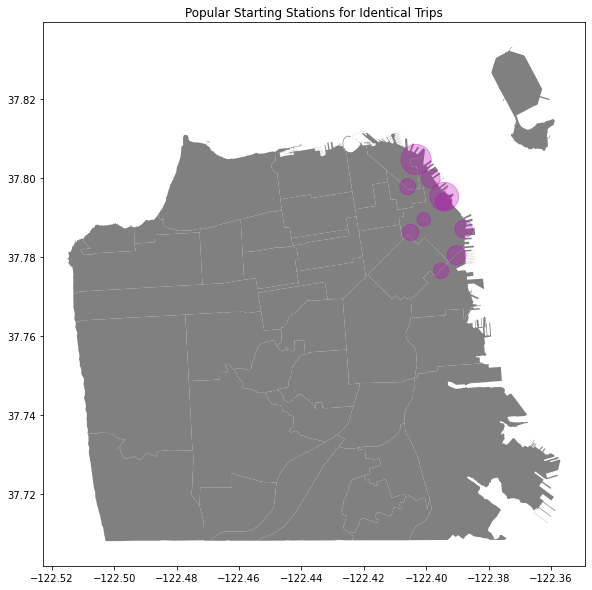

In [19]:
sf = gpd.read_file("Analysis Neighborhoods.geojson")
sf = sf.rename(columns={'geometry': 'geometry','nhood':'neighborhood_name'}).set_geometry('geometry')

popular_identical_starts['geometry'] = popular_identical_starts.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
crs = {'init': 'epsg:4326'}
data = gpd.GeoDataFrame(popular_identical_starts, crs=crs, geometry = 'geometry')

fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
data.plot(ax=sf_map, marker="o", markersize=data['total_identical_trips'] * 1.5, alpha=0.3, color='m')
ax.set_title("Popular Starting Stations for Identical Trips")
plt.show()

According to the above result, the 10 most popular starting stations for identical trips by Bay Area non-subscribers are all located in the tourist district of SF and nearby public transit stations.

<a id='p1'></a>**Proposal 1:** Promote the Access Pass (\$10 for unlimited 30-min rides for 24hrs) at these stations by offering a discount on additional Access Pass purchases for groups. This discount may encourage groups of non-subscribers to choose the bikeshare program over some other means of navigating the tourist district.

<a id='q5'></a>
### Bike Shortages and Surpluses

Popular stations may experience bike shortages or surpluses, and the transport of bikes (using trucks) to rectify imbalances can be costly. Incentivizing users to assist in this process can alleviate some of the costs.

In [26]:
%%bigquery station_outs
SELECT
    start_station_name,
    latitude,
    longitude,
    COUNT(*) AS total_starts
FROM `bigquery-public-data.san_francisco.bikeshare_trips` AS Trips
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS Stations
ON Trips.start_station_id = Stations.station_id
WHERE SUBSTRING(zip_code, 1, 2) = "94"
GROUP BY
    start_station_name,
    latitude,
    longitude
ORDER BY start_station_name

In [27]:
station_outs

,start_station_name,latitude,longitude,total_starts
0,2nd at Folsom,37.785299,-122.396236,21212
1,2nd at South Park,37.782259,-122.392738,24188
2,2nd at Townsend,37.780526,-122.390288,35155
3,5th S at E. San Salvador St,37.331957,-121.881630,10
4,5th St at Folsom St,37.780148,-122.403158,145
...,...,...,...,...
78,Townsend at 7th,37.771058,-122.402717,32470
79,University and Emerson,37.444521,-122.163093,872
80,Washington at Kearney,37.795425,-122.404767,989
81,Washington at Kearny,37.795425,-122.404767,5186


The above table lists the total number of trips started at each station, equivalent to the total outflow of bikes from that station over the span of the dataset.

In [28]:
%%bigquery station_ins
SELECT
    end_station_name,
    COUNT(*) AS total_ends
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE SUBSTRING(zip_code, 1, 2) = "94"
GROUP BY end_station_name
ORDER BY end_station_name

In [29]:
station_ins

,end_station_name,total_ends
0,2nd at Folsom,12589
1,2nd at South Park,22285
2,2nd at Townsend,39730
3,5th S at E. San Salvador St,20
4,5th St at Folsom St,135
...,...,...
78,Townsend at 7th,36066
79,University and Emerson,1120
80,Washington at Kearney,1336
81,Washington at Kearny,6967


The above table lists the total number of trips ended at each station, equivalent to the total inflow of bikes to that station over the span of the dataset.

Taking the difference between the inflow and outflow for each station gives the net bike flow for each station over the span of the dataset.

In [36]:
station_outs['total_ends'] = station_ins['total_ends']
station_outs['net_change'] = station_outs['total_ends'] - station_outs['total_starts']
station_changes = station_outs.sort_values(by=['net_change'])
negative_stations = station_changes.head(10)
positive_stations = station_changes.tail(10)

In [35]:
positive_stations[['start_station_name', 'net_change']]

,start_station_name,net_change
82,Yerba Buena Center of the Arts (3rd @ Howard),1758
81,Washington at Kearny,1781
28,Harry Bridges Plaza (Ferry Building),2036
23,Embarcadero at Vallejo,2151
5,5th at Howard,2177
60,San Francisco Caltrain 2 (330 Townsend),2726
78,Townsend at 7th,3596
2,2nd at Townsend,4575
35,Market at Sansome,6505
59,San Francisco Caltrain (Townsend at 4th),15731


In [38]:
negative_stations[['start_station_name', 'net_change']]

,start_station_name,net_change
27,Grant Avenue at Columbus Avenue,-10860
0,2nd at Folsom,-8623
48,Powell at Post (Union Square),-4952
8,Beale at Market,-4413
33,Market at 10th,-4135
77,Temporary Transbay Terminal (Howard at Beale),-3872
72,South Van Ness at Market,-2917
20,Embarcadero at Bryant,-2474
26,Golden Gate at Polk,-2127
1,2nd at South Park,-1903


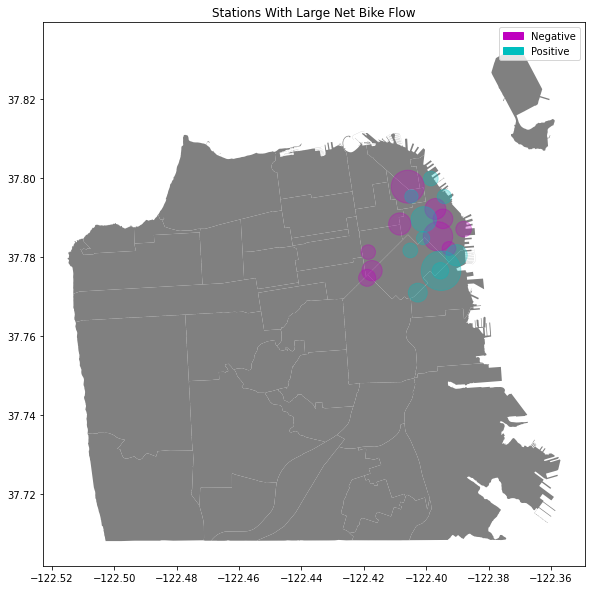

In [39]:
negative_stations['geometry'] = negative_stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
positive_stations['geometry'] = positive_stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
neg_data = gpd.GeoDataFrame(negative_stations, crs=crs, geometry = 'geometry')
pos_data = gpd.GeoDataFrame(positive_stations, crs=crs, geometry = 'geometry')

fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
neg_data.plot(ax=sf_map, marker="o", markersize=neg_data['net_change']/-10, alpha=0.3, color='m')
pos_data.plot(ax=sf_map, marker="o", markersize=pos_data['net_change']/10, alpha=0.3, color='c')
ax.set_title("Stations With Large Net Bike Flow")
neg_label = mpatches.Patch(color='m', label='Negative')
pos_label = mpatches.Patch(color='c', label='Positive')
plt.legend(handles=[neg_label, pos_label])
plt.show()

The stations shown above had the highest difference between inbound and outbound trips over the span of the dataset.

An alternative view of bike shortages and surpluses involves stations' status reports, which contain the number of available bikes and docks.

In [40]:
%%bigquery least_bikes
SELECT
    name,
    latitude,
    longitude,
    COUNT(*) AS times_unavailable
FROM `bigquery-public-data.san_francisco.bikeshare_status` AS Statuses
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS Stations
ON Statuses.station_id = Stations.station_id
WHERE bikes_available = 0
GROUP BY 
    name,
    latitude,
    longitude
ORDER BY times_unavailable DESC
LIMIT 10

In [41]:
least_bikes

,name,latitude,longitude,times_unavailable
0,2nd at Folsom,37.785299,-122.396236,44844
1,Commercial at Montgomery,37.794231,-122.402923,44728
2,Embarcadero at Vallejo,37.799953,-122.398525,35903
3,Embarcadero at Sansome,37.804770,-122.403234,32980
4,Clay at Battery,37.795001,-122.399970,32505
5,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,32027
6,Grant Avenue at Columbus Avenue,37.797900,-122.405942,31733
7,Market at 4th,37.786305,-122.404966,30800
8,Howard at 2nd,37.786978,-122.398108,27938
9,Broadway St at Battery St,37.798541,-122.400862,25496


The above table lists the 10 stations with the most status reports indicating no bikes were available - a bike shortage.

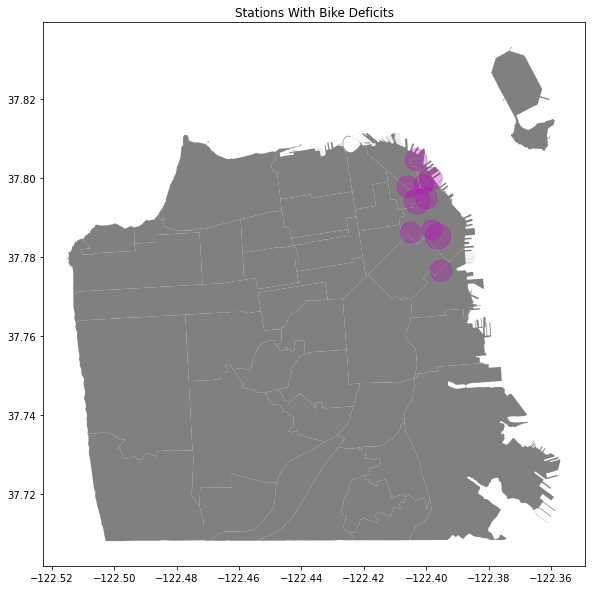

In [44]:
least_bikes['geometry'] = least_bikes.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
least_data = gpd.GeoDataFrame(least_bikes, crs=crs, geometry = 'geometry')

fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
least_data.plot(ax=sf_map, marker="o", markersize=least_data['times_unavailable']/70, alpha=0.3, color='m')
ax.set_title("Stations With Bike Deficits")
plt.show()

The stations shown above had the most status reports indicating a bike shortage: 0 bikes remaining.

In [42]:
%%bigquery most_bikes
SELECT
    name,
    latitude,
    longitude,
    COUNT(*) AS times_unavailable
FROM `bigquery-public-data.san_francisco.bikeshare_status` AS Statuses
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS Stations
ON Statuses.station_id = Stations.station_id
WHERE docks_available = 0
GROUP BY 
    name,   
    latitude,
    longitude
ORDER BY times_unavailable DESC
LIMIT 10

In [43]:
most_bikes

,name,latitude,longitude,times_unavailable
0,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,43079
1,Embarcadero at Bryant,37.787152,-122.388013,39401
2,Grant Avenue at Columbus Avenue,37.797900,-122.405942,33112
3,Embarcadero at Sansome,37.804770,-122.403234,25476
4,San Francisco Caltrain 2 (330 Townsend),37.776600,-122.395470,23605
5,Townsend at 7th,37.771058,-122.402717,18534
6,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,18036
7,Civic Center BART (7th at Market),37.781039,-122.411748,17017
8,Embarcadero at Vallejo,37.799953,-122.398525,16824
9,Powell Street BART,37.783871,-122.408433,14279


The above table lists the 10 stations with the most status reports indicating no docks were available - a bike surplus.

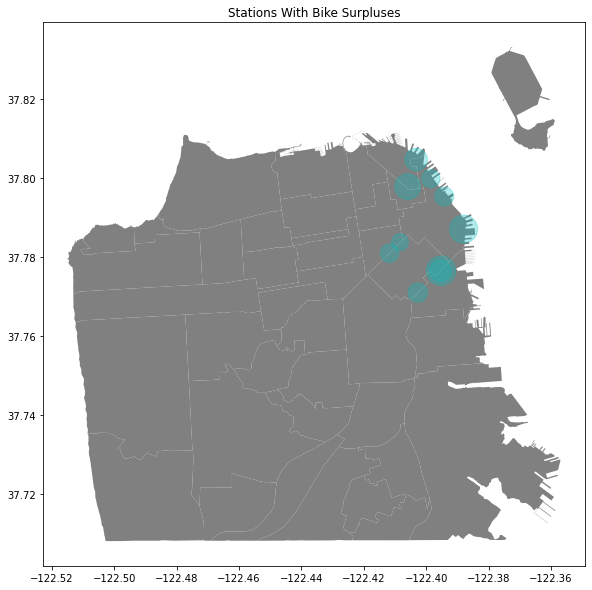

In [45]:
most_bikes['geometry'] = most_bikes.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
most_data = gpd.GeoDataFrame(most_bikes, crs=crs, geometry = 'geometry')

fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
most_data.plot(ax=sf_map, marker="o", markersize=most_data['times_unavailable']/50, alpha=0.3, color='c')
ax.set_title("Stations With Bike Surpluses")
plt.show()

The stations shown above had the most status reports indicating a bike surplus: 0 docks remaining.

In [57]:
%%bigquery subscriber_trip_durations
SELECT duration_sec
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE SUBSTRING(zip_code, 1, 2) = "94"
AND subscriber_type = "Subscriber"

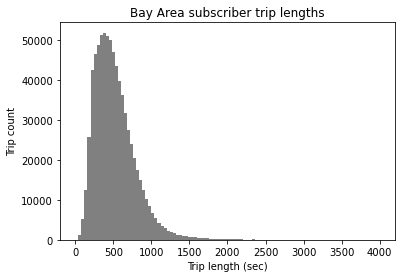

In [58]:
plt.hist(subscriber_trip_durations, 100, range=[0, 4000], facecolor='gray', align='mid')
plt.title('Bay Area subscriber trip lengths')
plt.xlabel('Trip length (sec)')
plt.ylabel('Trip count')
plt.show()

In [59]:
%%bigquery non_subscriber_trip_durations
SELECT duration_sec
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE SUBSTRING(zip_code, 1, 2) = "94"
AND EXTRACT(
    DAYOFWEEK FROM start_date
) NOT BETWEEN 2 AND 6

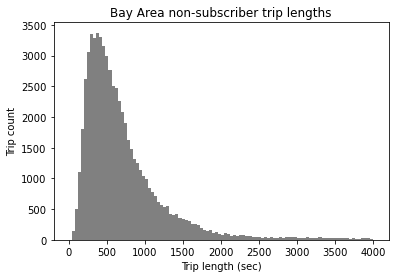

In [60]:
plt.hist(non_subscriber_trip_durations, 100, range=[0, 4000], facecolor='gray', align='mid')
plt.title('Bay Area non-subscriber trip lengths')
plt.xlabel('Trip length (sec)')
plt.ylabel('Trip count')
plt.show()

Subscribers get free 45-min trips (2700 sec) while non-subscribers pay a flat fee for 30-min trips (1800 sec); any additional trip time costs more. Based on the above distributions of trip lengths, few subscriber trips exceeded 2700 sec, while a larger fraction of non-subscriber trips exceeded 1800 sec.

This suggests that the extra cost is a deterrent for users interested in longer trips, but some users (mostly non-subscribers) are still interested enough in longer trips to pay extra for them. Thus, increased trip times could be used as a potential incentive.

<a id='p2'></a>**Proposal 2:** Reduce bike shortages/surpluses by offering extended ride times to both subscribers and non-subscribers for specific trips: "If you start your ride at station A and end your ride in station B, you get an extra 15 min added to your ride with no charge." The incentivized trips would be to/from stations that tend to experience (or are currently experiencing) bike shortages/surpluses.

In [91]:
%%bigquery least_bikes_morning
SELECT
    name,
    COUNT(*) AS times_unavailable
FROM `bigquery-public-data.san_francisco.bikeshare_status` AS Statuses
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS Stations
ON Statuses.station_id = Stations.station_id
WHERE bikes_available = 0
AND EXTRACT(
    HOUR FROM time
) BETWEEN 6 AND 11
GROUP BY name
ORDER BY times_unavailable DESC
LIMIT 10

In [92]:
least_bikes_morning

,name,times_unavailable
0,San Francisco Caltrain (Townsend at 4th),27396
1,Grant Avenue at Columbus Avenue,20960
2,Embarcadero at Bryant,16371
3,Temporary Transbay Terminal (Howard at Beale),13407
4,Powell at Post (Union Square),13223
5,Harry Bridges Plaza (Ferry Building),12302
6,San Francisco Caltrain 2 (330 Townsend),11909
7,Civic Center BART (7th at Market),10031
8,2nd at Folsom,9859
9,Embarcadero at Sansome,8419


The above table lists the 10 stations with the most status reports between 6am-noon indicating a bike shortage. Note the prevalence of public transit stations, likely due to commuters arriving in the city by train then biking to work.

In [93]:
%%bigquery least_bikes_afternoon
SELECT
    name,
    COUNT(*) AS times_unavailable
FROM `bigquery-public-data.san_francisco.bikeshare_status` AS Statuses
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS Stations
ON Statuses.station_id = Stations.station_id
WHERE bikes_available = 0
AND EXTRACT(
    HOUR FROM time
) BETWEEN 12 AND 17
GROUP BY name
ORDER BY times_unavailable DESC
LIMIT 10

In [94]:
least_bikes_afternoon

,name,times_unavailable
0,Beale at Market,9449
1,2nd at Folsom,8748
2,San Francisco Caltrain 2 (330 Townsend),8236
3,Embarcadero at Sansome,7809
4,Townsend at 7th,7691
5,Grant Avenue at Columbus Avenue,7672
6,Steuart at Market,6427
7,Embarcadero at Vallejo,6198
8,Embarcadero at Bryant,5608
9,Commercial at Montgomery,5572


The above table lists the 10 stations with the most status reports between noon-6pm indicating a bike shortage.

In [96]:
%%bigquery most_bikes_morning
SELECT
    name,
    COUNT(*) AS times_unavailable
FROM `bigquery-public-data.san_francisco.bikeshare_status` AS Statuses
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS Stations
ON Statuses.station_id = Stations.station_id
WHERE docks_available = 0
AND EXTRACT(
    HOUR FROM time
) BETWEEN 6 AND 11
GROUP BY name
ORDER BY times_unavailable DESC
LIMIT 10

In [97]:
most_bikes_morning

,name,times_unavailable
0,Embarcadero at Vallejo,9122
1,Townsend at 7th,7793
2,Embarcadero at Sansome,7014
3,2nd at South Park,6498
4,Howard at 2nd,6012
5,San Francisco Caltrain 2 (330 Townsend),5481
6,Grant Avenue at Columbus Avenue,5237
7,Commercial at Montgomery,5179
8,Santa Clara at Almaden,5006
9,5th at Howard,4445


The above table lists the 10 stations with the most status reports between 6am-noon indicating a bike surplus.

In [98]:
%%bigquery most_bikes_afternoon
SELECT
    name,
    COUNT(*) AS times_unavailable
FROM `bigquery-public-data.san_francisco.bikeshare_status` AS Statuses
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS Stations
ON Statuses.station_id = Stations.station_id
WHERE docks_available = 0
AND EXTRACT(
    HOUR FROM time
) BETWEEN 12 AND 17
GROUP BY name
ORDER BY times_unavailable DESC
LIMIT 10

In [99]:
most_bikes_afternoon

,name,times_unavailable
0,Embarcadero at Sansome,13777
1,San Francisco Caltrain (Townsend at 4th),6914
2,Embarcadero at Vallejo,6559
3,2nd at South Park,5390
4,Harry Bridges Plaza (Ferry Building),4459
5,Howard at 2nd,4171
6,Mountain View City Hall,3365
7,Townsend at 7th,3079
8,Santa Clara at Almaden,2651
9,University and Emerson,2592


The above table lists the 10 stations with the most status reports between noon-6pm indicating a bike surplus.

<a id='p3'></a>**Proposal 3:** During the time of day that a station is known to experience stress on the bike supply, incentivize users to make trips that counteract the current stress on the station, by:
  - Offering additional ride time (as in [Proposal 2](#p2)) to both subscribers and non-subscribers
  - Offering reduced unlock costs and/or additional time rates to non-subscribers

Additionally, impose extra charges on users who make trips that increase the current stress, by:
- Charging higher unlock costs for non-subscribers
- Charging higher additional time rates for both subscribers and non-subscribers